# CRISP-DM 

## Data Understanding

ข้อมูลมาจากsettarde API เเล้วใส่ในฐานข้อมูล Cassandra

In [93]:
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
from datetime import datetime

In [94]:
cluster = Cluster(['127.0.0.1'])
session = cluster.connect()
session.set_keyspace('data_stock')

In [95]:
rows_price = session.execute("""
    SELECT * FROM candlestick_data ALLOW FILTERING
""")
df_cand = pd.DataFrame(rows_price)
df_cand['time'] = pd.to_datetime(df_cand['time'])
df_cand = df_cand.sort_values(['symbol', 'time'])


In [96]:
df_cand.head(10)

,symbol,time,close_price,high_price,low_price,open_price,value,volume
362761,24CS,2022-10-03,10.20,10.20,7.10,7.10,0.0,559474246
362762,24CS,2022-10-04,7.15,11.10,7.15,10.70,0.0,330716796
362763,24CS,2022-10-05,5.15,6.45,5.05,5.85,0.0,361105489
362764,24CS,2022-10-06,5.20,5.45,4.70,5.40,0.0,232684182
362765,24CS,2022-10-07,5.00,5.15,4.76,5.10,0.0,131780847
362766,24CS,2022-10-10,5.00,5.15,4.88,4.98,0.0,51045639
362767,24CS,2022-10-11,4.48,5.05,4.48,5.00,0.0,43520132
362768,24CS,2022-10-12,3.88,4.62,3.88,4.50,0.0,85779188
362769,24CS,2022-10-17,3.68,3.90,3.56,3.88,0.0,9027003
362770,24CS,2022-10-18,3.88,3.90,3.64,3.72,0.0,11371787


### ดึงข้อมูลของFundametalของเเต่ละหุ้น โดยเอาคอลัมท์ EPS,PE,PBV,PercentYield

EPS=Profit per share(Negative, indicating a loss)

PE=Zero due  to company  losses

PBV= Relatively high, indicating  a premium valuation

PercentYield = 

In [97]:
rows_fin2 = session.execute("""
    SELECT symbol,eps,pe,pbv,percentYield FROM financal_data_fromsettradeAPI ALLOW FILTERING
""")
df_fun= pd.DataFrame(rows_fin2)
df_fun.head(10)

,symbol,eps,pe,pbv,percentyield
0,PPPM,0.02000,0.00,0.70,0.00
1,TPCH,0.24112,7.90,0.34,13.91
2,KPNREIT,NaN,NaN,0.23,0.00
3,POLY,0.27632,12.89,2.42,6.38
4,QHBREIT,NaN,NaN,0.41,0.00
5,VCOM,0.21428,7.85,1.48,10.79
6,KDH,4.12186,10.62,1.93,3.01
7,NVD,-0.00942,38.87,0.32,0.00
8,JDF,0.04224,12.19,1.35,4.85
9,SVR,-0.03402,0.00,0.34,0.00


## Data preparation

### เอาข้อมูลเฉพาะของล่าสุด

In [98]:
candlestick_data=df_cand
candlestick_data["time"] = pd.to_datetime(candlestick_data["time"])
# ✅ ดึงแท่งเทียนล่าสุดของแต่ละ symbol
latest_candle = candlestick_data.sort_values("time").groupby("symbol").tail(1)
latest_candle.shape

(912, 8)

In [99]:
latest_candle.head()

,symbol,time,close_price,high_price,low_price,open_price,value,volume
296488,ACAP,2023-05-17,0.33,0.36,0.21,0.22,0.0,13918556
377055,TAPAC,2024-05-02,0.52,0.53,0.46,0.47,0.0,1675203
29119,KKC,2024-07-26,0.04,0.04,0.03,0.03,0.0,4462175
570667,JKN,2024-09-16,0.31,0.32,0.25,0.26,0.0,43155573
340860,CV,2025-02-28,0.20,0.24,0.18,0.22,0.0,18892801


### เพิ่มคอลัมท์ Marketcap โดยเอา คอลัมท์ Close_price คูณ Volume

In [100]:
# ✅ 1) ดึงแท่งล่าสุดของแต่ละ symbol
df_latest_candle = (
    df_cand.sort_values("time")
    .groupby("symbol", as_index=False)
    .tail(1)  # หรือใช้ .last() ก็ได้หลัง sort แล้ว
)

# ✅ 2) Merge กับข้อมูล fundamental
df = pd.merge(df_fun, df_latest_candle, on="symbol", how="inner")

# ✅ 3) คำนวณ marketcap
df["marketcap"] = df["close_price"] * df["volume"]


In [101]:
df.head(10)

,symbol,eps,pe,pbv,percentyield,time,close_price,high_price,low_price,open_price,value,volume,marketcap
0,PPPM,0.02000,0.00,0.70,0.00,2025-05-28,0.49,0.51,0.48,0.49,0.0,313650,153688.502991
1,TPCH,0.24112,7.90,0.34,13.91,2025-05-28,3.08,3.10,3.04,3.10,0.0,52708,162340.635979
2,KPNREIT,NaN,NaN,0.23,0.00,2025-05-22,2.56,2.56,2.56,2.56,0.0,100,255.999994
3,POLY,0.27632,12.89,2.42,6.38,2025-05-28,6.95,6.95,6.65,6.90,0.0,5100,35444.999027
4,QHBREIT,NaN,NaN,0.41,0.00,2025-05-28,3.44,3.44,3.42,3.44,0.0,140301,482635.448028
5,VCOM,0.21428,7.85,1.48,10.79,2025-05-28,2.50,2.62,2.50,2.56,0.0,335100,837750.000000
6,KDH,4.12186,10.62,1.93,3.01,2025-05-22,85.00,85.00,84.75,85.00,0.0,1200,102000.000000
7,NVD,-0.00942,38.87,0.32,0.00,2025-05-28,1.00,1.02,1.00,1.02,0.0,16301,16301.000000
8,JDF,0.04224,12.19,1.35,4.85,2025-05-28,1.84,1.85,1.84,1.85,0.0,200,368.000007
9,SVR,-0.03402,0.00,0.34,0.00,2025-05-28,0.58,0.59,0.57,0.58,0.0,47400,27491.999209


### เช็คข้อมูลที่เป็นNAN เเล้วดรอป (เหตุผล หุ้นบางตัวอาจจะพึ่งเข้าตลาดหลักทรัพร์)

In [102]:
df.isnull().sum()

symbol           0
eps             65
pe              72
pbv              9
percentyield     8
time             0
close_price      0
high_price       0
low_price        0
open_price       0
value            0
volume           0
marketcap        0
dtype: int64

In [103]:
df.dropna(inplace=True)  # ลบแถวที่มีค่าว่าง

In [104]:
df.isnull().sum()

symbol          0
eps             0
pe              0
pbv             0
percentyield    0
time            0
close_price     0
high_price      0
low_price       0
open_price      0
value           0
volume          0
marketcap       0
dtype: int64

In [105]:
df.columns

Index(['symbol', 'eps', 'pe', 'pbv', 'percentyield', 'time', 'close_price',
       'high_price', 'low_price', 'open_price', 'value', 'volume',
       'marketcap'],
      dtype='object')

In [106]:
df = df.drop(columns=['time', 'close_price',
       'high_price', 'low_price', 'open_price', 'value', 'volume',])

### แยกกลุ่มของข้อมูล Technical

โดยใช้เส้นEMA

a: แรงมาก/overbought — Close ≥ EMA5 และ RSI ≥ 70

b: ขาขึ้นชัด — Close ≥ EMA35 และ EMA35 ≥ EMA89

c: Sideways เหนือ EMA89 — Close ≥ EMA89 และแถบ EMA ระยะสั้น (5/15/35/89) แคบ: (max-min)/mean ≤ band_pct (ค่าเริ่ม 1.5%)

d: ขาลง — Close < EMA89 และ Close < EMA200 และ EMA89 < EMA200

e: Crash — ลำดับลดหลั่นแรง Close < EMA5 < EMA15 < EMA35 < EMA89 < EMA200 และ RSI ≤ 30

In [107]:
import ta
import numpy as np
import pandas as pd

def compute_technical_grades(df_candle, band_pct=0.015):
    df_result = []

    for symbol, df_sym in df_candle.groupby('symbol'):
        df_sym = df_sym.sort_values('time').copy()

        # ✅ คำนวณ EMA และ RSI
        df_sym['ema5'] = df_sym['close_price'].ewm(span=5, adjust=False).mean()
        df_sym['ema15'] = df_sym['close_price'].ewm(span=15, adjust=False).mean()
        df_sym['ema35'] = df_sym['close_price'].ewm(span=35, adjust=False).mean()
        df_sym['ema89'] = df_sym['close_price'].ewm(span=89, adjust=False).mean()
        df_sym['ema200'] = df_sym['close_price'].ewm(span=200, adjust=False).mean()
        df_sym['rsi'] = ta.momentum.RSIIndicator(close=df_sym['close_price'], window=14).rsi()

        # ✅ ใช้ข้อมูลแถวสุดท้าย (ล่าสุด)
        row = df_sym.iloc[-1]
        try:
            c = row['close_price']
            r = row['rsi']
            e5, e15, e35, e89, e200 = row['ema5'], row['ema15'], row['ema35'], row['ema89'], row['ema200']

            # ✅ Logic การให้เกรด
            if c >= e5 and r >= 70:
                grade = 'a'
            elif c >= e35 and e35 >= e89:
                grade = 'b'
            elif c >= e89 and (max([e5,e15,e35,e89]) - min([e5,e15,e35,e89])) / np.mean([e5,e15,e35,e89]) <= band_pct:
                grade = 'c'
            elif c < e89 and c < e200 and e89 < e200:
                grade = 'd'
            elif c < e5 < e15 < e35 < e89 < e200 and r <= 30:
                grade = 'e'
            else:
                grade = None
        except:
            grade = None
        df_result.append({'symbol': symbol, 'trend_grade': grade})
        # ✅ เก็บข้อมูลทั้งหมดลงใน dict
        df_result.append({
            'symbol': symbol,
            'trend_grade': grade,
            'time': row['time'],
            'close_price': row['close_price'],
            'high_price': row['high_price'],
            'low_price': row['low_price'],
            'open_price': row['open_price'],
            'value': row['value'],
            'volume': row['volume']
        })

    return pd.DataFrame(df_result)


In [108]:
df_result = compute_technical_grades(df_cand)    

In [109]:
df_result.head(10)

,symbol,trend_grade,time,close_price,high_price,low_price,open_price,value,volume
0,24CS,d,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,24CS,d,2025-05-28,1.00,1.11,0.98,1.08,0.0,43744006.0
2,2S,None,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,2S,None,2025-05-28,2.32,2.32,2.30,2.32,0.0,14600.0
4,3BBIF,b,NaT,NaN,NaN,NaN,NaN,NaN,NaN
5,3BBIF,b,2025-05-28,6.00,6.05,5.90,5.90,0.0,9248268.0
6,A,d,NaT,NaN,NaN,NaN,NaN,NaN,NaN
7,A,d,2025-08-19,4.82,4.84,4.82,4.82,366520.0,76000.0
8,A5,d,NaT,NaN,NaN,NaN,NaN,NaN,NaN
9,A5,d,2025-05-28,2.18,2.26,2.10,2.16,0.0,340700.0


### ดรอปหุ้นที่เป็นNAN

In [110]:
df_result.dropna(inplace=True)

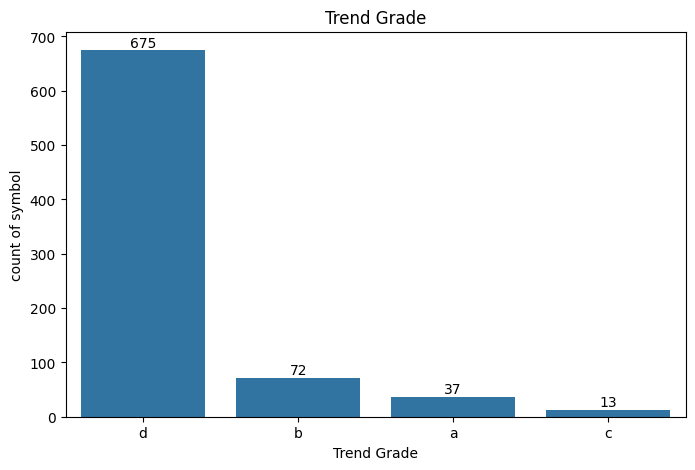

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
ax = sns.countplot(data=df_result, x="trend_grade", order=df_result["trend_grade"].value_counts().index)

plt.title("Trend Grade")
plt.xlabel("Trend Grade")
plt.ylabel("count of symbol")

# ✅ ใส่ตัวเลขบนแท่ง
for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())), 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='bottom', fontsize=10
    )

plt.show()


### เเยกกลุ่มของข้อมูล Fundematal โดยใช้Mechine learning (KMEANS)

In [ ]:
# ✅ Clustering กลุ่ม A–E ด้วย KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = ['eps', 'pe', 'pbv', 'percentyield', 'marketcap']
X = df[features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X_scaled)
df.loc[X.index, 'group'] = kmeans_labels

group_map = {i: chr(65+i) for i in range(5)}
df['group'] = df['group'].map(group_map)

In [113]:
df.head(10)

,symbol,eps,pe,pbv,percentyield,marketcap,group
0,PPPM,0.02000,0.00,0.70,0.00,153688.502991,A
1,TPCH,0.24112,7.90,0.34,13.91,162340.635979,B
3,POLY,0.27632,12.89,2.42,6.38,35444.999027,B
5,VCOM,0.21428,7.85,1.48,10.79,837750.000000,B
6,KDH,4.12186,10.62,1.93,3.01,102000.000000,A
7,NVD,-0.00942,38.87,0.32,0.00,16301.000000,A
8,JDF,0.04224,12.19,1.35,4.85,368.000007,B
9,SVR,-0.03402,0.00,0.34,0.00,27491.999209,A
10,SUSCO,0.11000,8.75,0.55,8.37,417893.841455,B
11,STP,0.92828,6.74,1.37,5.60,74480.001450,B


In [114]:
# ✅ 1) สมมติว่า df_graded มี: symbol | trend_grade
#         และ df มี:        symbol | group

# ✅ 2) Merge โดยใช้คอลัมน์ 'symbol'
df_merged = pd.merge(df, df_result[['symbol', 'trend_grade']], on='symbol', how='inner')

# ✅ 3) สร้างคอลัมน์ quadrant (เช่น Aa, Be, Dc, etc.)
df_merged['quadrant'] = df_merged['group'] + df_merged['trend_grade']

In [115]:
df_merged.head(10)

,symbol,eps,pe,pbv,percentyield,marketcap,group,trend_grade,quadrant
0,TPCH,0.24112,7.90,0.34,13.91,162340.635979,B,d,Bd
1,POLY,0.27632,12.89,2.42,6.38,35444.999027,B,d,Bd
2,KDH,4.12186,10.62,1.93,3.01,102000.000000,A,d,Ad
3,NVD,-0.00942,38.87,0.32,0.00,16301.000000,A,d,Ad
4,JDF,0.04224,12.19,1.35,4.85,368.000007,B,d,Bd
5,SVR,-0.03402,0.00,0.34,0.00,27491.999209,A,d,Ad
6,SUSCO,0.11000,8.75,0.55,8.37,417893.841455,B,d,Bd
7,STP,0.92828,6.74,1.37,5.60,74480.001450,B,d,Bd
8,VGI,0.00224,85.27,1.20,0.63,21839.999008,A,d,Ad
9,NCP,0.06168,10.60,1.19,5.76,17249.999642,B,b,Bb


In [116]:
import plotly.graph_objects as go
df_result=df_merged
# ✅ จัดกลุ่มหุ้นตาม quadrant
quadrant_groups = df_result.groupby('quadrant')['symbol'].apply(list).to_dict()

# ✅ กำหนดลำดับของแกน
financial_levels = ['A', 'B', 'C', 'D', 'E']  # A = Strong fundamentals
trend_levels = ['a', 'b', 'c', 'd', 'e']      # a = Bullish, e = Crash

# ✅ เตรียมข้อมูลแต่ละเซลล์ในตาราง (5x5)
plot_table = []
for f in financial_levels:
    row = []
    for t in trend_levels:
        code = f + t
        stocks = quadrant_groups.get(code, [])
        if stocks:
            stock_list = "<br>".join(stocks[:10])  # แสดงสูงสุด 10 ตัว
            cell_text = f"<b>{code}</b><br>{stock_list}"
        else:
            cell_text = f"<b>{code}</b><br>-"
        row.append(cell_text)
    plot_table.append(row)

# ✅ สร้างสีของแต่ละแถวตามกลุ่มพื้นฐาน A–E
colors = [[{'A': '#2ecc71', 'B': '#58d68d', 'C': '#f4d03f', 'D': '#f39c12', 'E': '#e74c3c'}[f]]*5 for f in financial_levels]

# ✅ Plotly Table
fig = go.Figure(data=go.Table(
    header=dict(
        values=["Super Bullish", "Up Trend", "Sideway", "Down Trend", "Crash"],
        fill_color="#dcdcdc",
        align="center",
        font=dict(color="black", size=14)
    ),
    cells=dict(
        values=plot_table,
        fill_color=colors,
        align="center",
        height=100,
        font=dict(color="white", size=12)
    )
))

# ✅ ตั้งชื่อกราฟ
fig.update_layout(title="📊 Stock Quadrant Table (Aa–Ee) จาก Rule-Based or Model")
fig.show()


## Modelling

In [117]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score

In [118]:
# ✅ Features และ Quadrant (สมมุติ df เตรียมไว้แล้ว)
features = ['eps', 'pe', 'pbv', 'percentyield', 'marketcap']
df = df_result.dropna(subset=features + ['group', 'trend_grade'])
df['quadrant'] = df['group'] + df_result['trend_grade']  # เช่น 'Aa', 'Bb'



In [119]:
df.head(10)

,symbol,eps,pe,pbv,percentyield,marketcap,group,trend_grade,quadrant
0,TPCH,0.24112,7.90,0.34,13.91,162340.635979,B,d,Bd
1,POLY,0.27632,12.89,2.42,6.38,35444.999027,B,d,Bd
2,KDH,4.12186,10.62,1.93,3.01,102000.000000,A,d,Ad
3,NVD,-0.00942,38.87,0.32,0.00,16301.000000,A,d,Ad
4,JDF,0.04224,12.19,1.35,4.85,368.000007,B,d,Bd
5,SVR,-0.03402,0.00,0.34,0.00,27491.999209,A,d,Ad
6,SUSCO,0.11000,8.75,0.55,8.37,417893.841455,B,d,Bd
7,STP,0.92828,6.74,1.37,5.60,74480.001450,B,d,Bd
8,VGI,0.00224,85.27,1.20,0.63,21839.999008,A,d,Ad
9,NCP,0.06168,10.60,1.19,5.76,17249.999642,B,b,Bb


In [120]:
df.shape

(735, 9)

In [121]:
# ✅ Encode Quadrant
le = LabelEncoder()
y_encoded = le.fit_transform(df['quadrant'])

# ✅ Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])
X_indices = df.index.values  # เก็บ index เดิมไว้

# ✅ Split
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    torch.tensor(X_scaled, dtype=torch.float32),
    torch.tensor(y_encoded, dtype=torch.long),
    X_indices,
    test_size=0.2,
    random_state=42
)

# ✅ Neural Network
class ANN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        return self.model(x)

# ✅ Train model
input_size = X_train.shape[1]
num_classes = len(le.classes_)
model = ANN(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

# ✅ Predict
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test)
    y_pred = torch.argmax(y_pred_logits, axis=1)

# ✅ Score
acc = accuracy_score(y_test.numpy(), y_pred.numpy())
f1 = f1_score(y_test.numpy(), y_pred.numpy(), average='macro')
print(f"\n📊 Accuracy: {acc:.4f}")
print(f"🎯 F1 Score (macro): {f1:.4f}")


Epoch 10 | Loss: 2.3887
Epoch 20 | Loss: 2.0814
Epoch 30 | Loss: 1.6860
Epoch 40 | Loss: 1.2981
Epoch 50 | Loss: 1.0593
Epoch 60 | Loss: 0.9246
Epoch 70 | Loss: 0.8350
Epoch 80 | Loss: 0.7733
Epoch 90 | Loss: 0.7322
Epoch 100 | Loss: 0.7145

📊 Accuracy: 0.8571
🎯 F1 Score (macro): 0.1966


## Evaluation

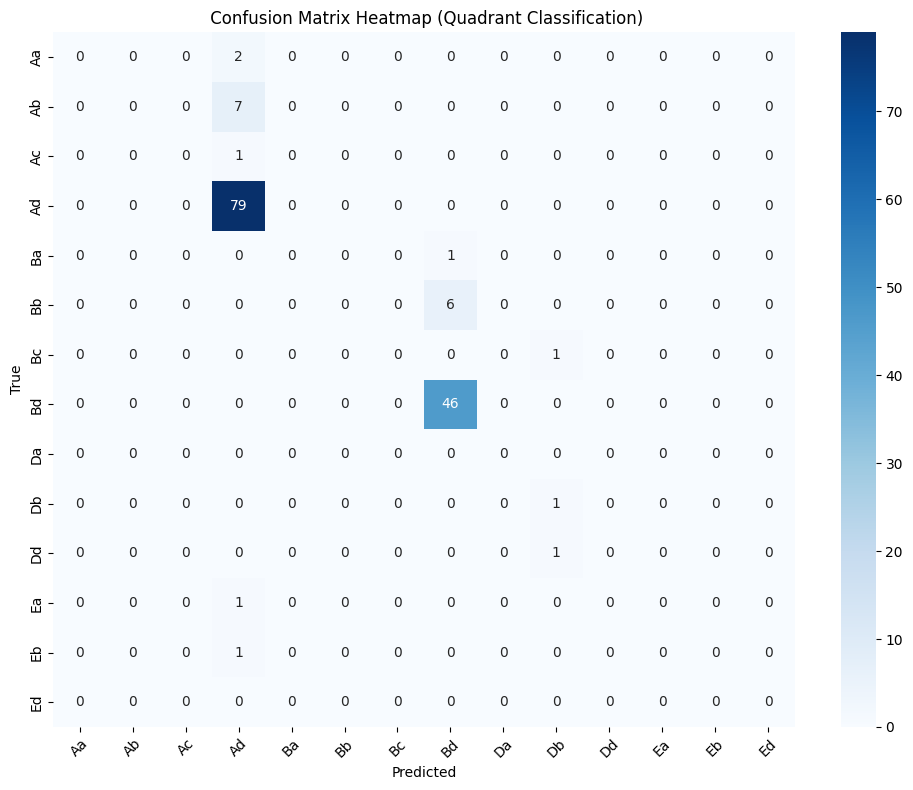

In [122]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Decode labels
y_test_labels = le.inverse_transform(y_test.numpy())
y_pred_labels = le.inverse_transform(y_pred.numpy())

# ✅ Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)

# ✅ Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            yticklabels=le.classes_, xticklabels=le.classes_)

plt.xticks(rotation=45)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(" Confusion Matrix Heatmap (Quadrant Classification)")
plt.tight_layout()
plt.show()


In [123]:
import plotly.graph_objects as go

# ✅ ใช้ df_merged ที่มี symbol + quadrant
df_result = df_merged.copy()

# ✅ Group หุ้นตาม quadrant
quadrant_groups = df_result.groupby('quadrant')['symbol'].apply(list).to_dict()

# ✅ Define ลำดับแกน
financial_levels = ['A', 'B', 'C', 'D', 'E']
trend_levels = ['a', 'b', 'c', 'd', 'e']

# ✅ เตรียมตาราง 5x5 (Aa–Ee)
plot_table = []
for f in financial_levels:
    row = []
    for t in trend_levels:
        code = f + t
        stocks = quadrant_groups.get(code, [])
        if stocks:
            stock_list = "<br>".join(stocks[:10])  # จำกัดไม่เกิน 10 ตัว
            cell_text = f"<b>{code}</b><br><span style='color:white'>{stock_list}</span>"
        else:
            cell_text = f"<b>{code}</b><br>-"
        row.append(cell_text)
    plot_table.append(row)

# ✅ กำหนดสีพื้นตามระดับ A–E
color_map = {'A': '#2ecc71', 'B': '#58d68d', 'C': '#f4d03f', 'D': '#f39c12', 'E': '#e74c3c'}
colors = [[color_map[f]] * 5 for f in financial_levels]

# ✅ วาดตาราง Plotly
fig = go.Figure(data=go.Table(
    header=dict(
        values=["Super Bullish", "Up Trend", "Sideway", "Down Trend", "Crash"],
        fill_color="#dcdcdc",
        align="center",
        font=dict(color="black", size=14)
    ),
    cells=dict(
        values=plot_table,
        fill_color=colors,
        align="center",
        height=80,
        font=dict(color="white", size=12)
    )
))

fig.update_layout(title="📊 Stock Quadrant Table (Aa–Ee) จาก Rule-Based หรือ Neural Net")
fig.show()
